# FX price prediction using LSTM

## Step 1.1 - Importing the Libraries

In [1]:
from pandas import read_csv
from pandas import datetime
from pandas import concat
from pandas import DataFrame
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from math import sqrt
from keras import regularizers
import pandas as pd
from keras.utils.vis_utils import plot_model
from pandas.tools.plotting import lag_plot
from pandas import Series
from pandas.tools.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns

Using TensorFlow backend.


## Step 1.2 - Load the Dataset and check for Autocorrelation

In [2]:
np.random.seed(1711)

def parser(x):
    return datetime.strptime(x,'%m-%d-%Y')
dataset = read_csv('usdinr_dataset.csv',header=0,parse_dates=[0],date_parser=parser)


In [3]:
print(dataset.head())

        Date  USD/INR  BSE Sensex  Gold Price
0 2018-01-19    63.83    35511.58      1333.1
1 2018-01-18    63.87    35260.29      1327.2
2 2018-01-17    63.89    35081.82      1339.2
3 2018-01-16    64.02    34771.05      1337.1
4 2018-01-15    63.52    34843.51      1341.8


In [4]:
dataset.describe()

,USD/INR,BSE Sensex,Gold Price
count,1712.000000,1712.000000,1712.000000
mean,60.557062,23674.218954,1359.342710
std,6.052800,5131.638246,200.241992
min,44.070000,15175.080000,1050.800000
25%,55.350000,18762.852500,1222.450000
50%,62.145000,24783.465000,1287.300000
75%,65.150000,27827.757500,1563.025000
max,68.810000,35511.580000,1888.700000


/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:3726: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


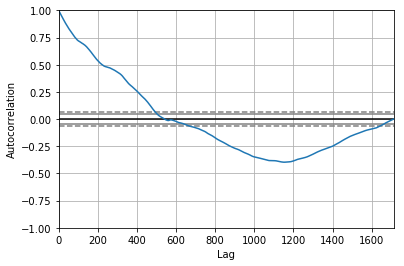

In [5]:
series = Series.from_csv('usdinr_dataset.csv',header=0)
autocorrelation_plot(series)
pyplot.show()

In [6]:
dataset.shape

(1712, 4)

## Step 1.2.1. Check for correlation

Good to have both positively and negatively correlated assets in the training set

In [7]:
corr = dataset.corr()
print(corr)

             USD/INR  BSE Sensex  Gold Price
USD/INR     1.000000    0.755530   -0.856715
BSE Sensex  0.755530    1.000000   -0.721223
Gold Price -0.856715   -0.721223    1.000000


In [8]:
def diagonal_correlation_matrix():
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = pyplot.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

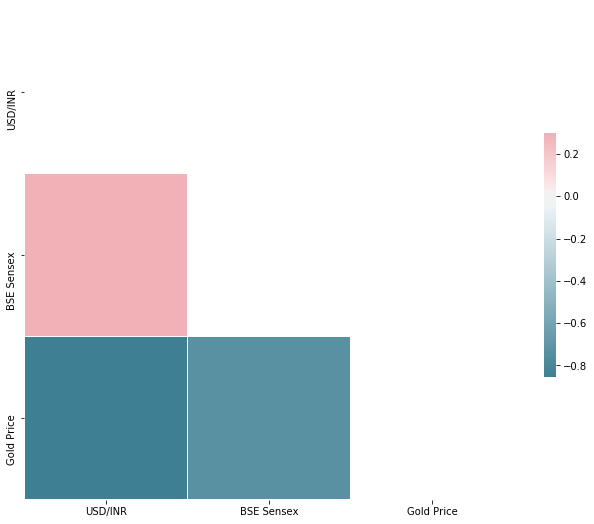

In [9]:
diagonal_correlation_matrix()

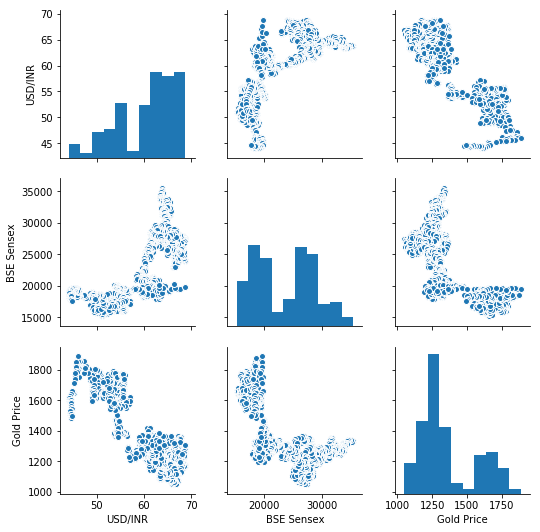

In [10]:

sns.pairplot(dataset)

## Step 1.3 -  Plot a graph to show the trend in the exchange rates

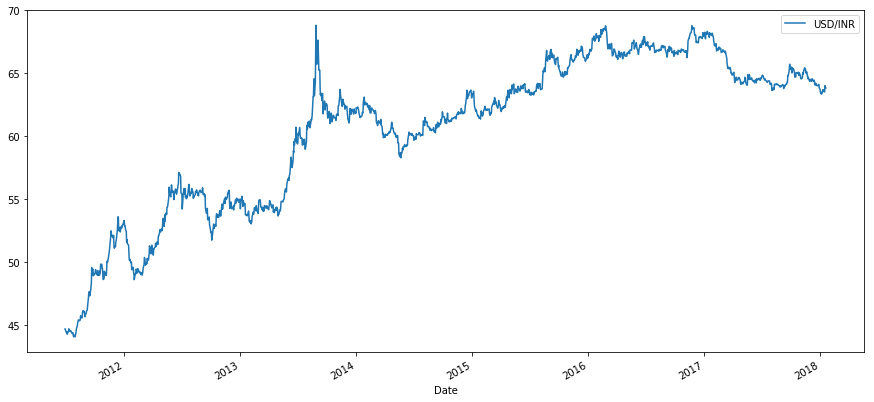

In [11]:
dataset.plot(y='USD/INR',x='Date', figsize=(15, 7))
pyplot.show()

In [12]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
# load dataset
dataset = read_csv('usdinr_dataset.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5]],axis=1,inplace=True)

In [14]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.798707   1.000000   0.336914  0.800323
2   0.800323   0.987643   0.329872  0.801132
3   0.801132   0.978868   0.344194  0.806386
4   0.806386   0.963586   0.341687  0.786176
5   0.786176   0.967149   0.347297  0.789814


In [15]:
values = reframed.values
n_test = 277
train = values[n_test:,:]
test = values[:n_test,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1434, 1, 3) (1434,) (277, 1, 3) (277,)


In [ ]:
model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2]),kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse'])

In [ ]:
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
def get_y_hat(test_X, test_y):
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    
    inv_yhat = inv_yhat.reshape((277,1))
    inv_y = inv_y.reshape((277,1))
    
    inv_yhat = pd.DataFrame(inv_yhat)
    inv_y = pd.DataFrame(inv_y)
    inv_yhat += 0.15
    
    return inv_yhat, inv_y

In [ ]:
inv_yhat, inv_y = get_y_hat(test_X, test_y)
pyplot.figure(figsize=(15,7))
pyplot.plot(inv_yhat,label='Predicted')
pyplot.plot(inv_y,label='Actual')
pyplot.legend()

In [ ]:
errr = inv_y-inv_yhat

In [ ]:
errr.plot(figsize=(15, 5))
pyplot.show()

In [ ]:
errr.describe()

# 2. Feature engineering with XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
CNHI = {"stock_name":"CNH Industrial NV", "data": pd.read_csv("Google_Stock_Price_Train.csv")}

In [ ]:
CNHI['data'].head()

In [ ]:
Predictors = pd.DataFrame({"sma2":CNHI["data"].Open.rolling(window=2).mean()})

In [ ]:
Predictors["sma2_1"] = Predictors.sma2.shift(1)

In [ ]:
Predictors.head(n=10)

In [ ]:
Predictors["sma2_increment"] = Predictors.sma2.diff()

In [ ]:
Predictors["sma2_1_increment"] = Predictors.sma2_1.diff()  

In [ ]:
Predictors["sma2_increment"] = Predictors.sma2.diff()  
 
Predictors["sma2_1_increment"] = Predictors.sma2_1.diff()  
 
Predictors["vol_increment"] = CNHI["data"].Volume.diff()
 
Predictors["vol_rel_increment"] = CNHI["data"].Volume.diff() / CNHI["data"].Volume
 
Predictors["open_1"] = CNHI["data"].Open.shift(1)
 
Predictors["open_incr"] = CNHI["data"].Open - CNHI["data"].Open.shift(1)
 
Predictors["open"] = CNHI["data"].Open
 
# The rows with nulls generated by rolling values will be removed.
Predictors = Predictors.dropna()

In [ ]:
Predictors.head()

In [ ]:
target = pd.DataFrame({"value":Predictors.sma2.shift(-1) - Predictors.sma2}).dropna()

In [ ]:
X = pd.merge(Predictors, target,left_index=True,right_index=True)[Predictors.columns]
y = pd.merge(Predictors, target,left_index=True,right_index=True)[target.columns]
print(X.head())

In [ ]:
train_samples = int(X.shape[0] * 0.65)
 
X_train = X.iloc[:train_samples]
X_test = X.iloc[train_samples:]
 
y_train = y.iloc[:train_samples]
y_test = y.iloc[train_samples:]

In [ ]:
def getBinary(val):
    if val>0:
        return 1
    else:
        return 0
 

y_test_binary = pd.DataFrame(y_test["value"].apply(getBinary))

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.01)

In [ ]:
xgbModel = regressor.fit(X_train,y_train.value.apply(getBinary))
 
y_predicted = xgbModel.predict(X_test)
y_predicted_binary = [1 if yp >=0.5 else 0 for yp in y_predicted] # (y_predicted > 0.5)
 
print ('Model accuracy = %.3f' % accuracy_score(y_test_binary,y_predicted_binary))

In [ ]:
fig = pyplot.figure(figsize=(8,8))
pyplot.xticks(rotation='vertical')
pyplot.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
pyplot.show()

## Other ways to predict prices

1. CNN
2. Trend LR
3. RL
4. NLP